# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment
The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [1]:
from unityagents import UnityEnvironment
import random
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
def MSG(txt):
    print('\n',datetime.now().strftime("%Y-%m-%d %H:%M:%S:"), str(txt))
from maddpg_agents import DDPGAgent, MADDPG
import sys
env = UnityEnvironment(file_name="data/Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
obs_size = states.shape[1]
state_size = obs_size * states.shape[0]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], obs_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Modified DDPG

[MADDPG](https://arxiv.org/abs/1706.02275) is an actor-critic, model-free deep reinforcement learning methods for multi-agent domains.
![MADDPG](src/img/maddpg.png)

Details of our algorithm:

1. 2-hidden layer (relu+bn) + tanh outlayer Actor Netwok
2. 2-hidden layer (relu+bn) + Linear outlayer  Critic Netwok
3. independent Critic/Actor Network and OuNoise process (with noise reduce factor) for each agent

Some hyper-parameters:

Hyper-Parameter | Value | Description
----------|-----------|--------------
BUFFER_SIZE | 2e6  | replay buffer size
BATCH_SIZE | 1024        | minibatch size
GAMMA | 0.99           | discount factor
TAU | 1e-3              | for soft update of target parameters
LR_ACTOR | 1e-3         | learning rate of the actor
LR_CRITIC | 1e-3        | learning rate of the critic
WEIGHT_DECAY | 1e-5        | L2 weight decay
UPDATE_EVERY | 100       | how often to update the network
LEARN_TIMES | 50        | how many times to learn each avtive step
NOISE_REDUCE | 0.9997 | reduce factor of noise in action


 2018-11-15 01:15:05: start!
Episode 100	Winner is agent 0	Average Score on 100 Episode: 0.005
Episode 200	Winner is agent 0	Average Score on 100 Episode: 0.005
Episode 300	Winner is agent 0	Average Score on 100 Episode: 0.005
Episode 400	Winner is agent 1	Average Score on 100 Episode: 0.010
Episode 500	Winner is agent 1	Average Score on 100 Episode: 0.022
Episode 600	Winner is agent 1	Average Score on 100 Episode: 0.029
Episode 700	Winner is agent 1	Average Score on 100 Episode: 0.037
Episode 800	Winner is agent 1	Average Score on 100 Episode: 0.039
Episode 900	Winner is agent 1	Average Score on 100 Episode: 0.055
Episode 1000	Winner is agent 1	Average Score on 100 Episode: 0.087
Episode 1100	Winner is agent 1	Average Score on 100 Episode: 0.112
Episode 1200	Winner is agent 0	Average Score on 100 Episode: 0.157
Episode 1300	Winner is agent 0	Average Score on 100 Episode: 0.195
Episode 1400	Winner is agent 0	Average Score on 100 Episode: 0.239
Episode 1500	Winner is agent 0	Average Sc

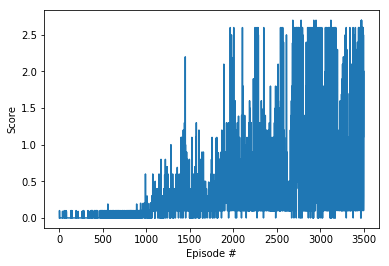

In [4]:
agent_list = [
    DDPGAgent(obs_size, state_size, action_size, random_seed = 2018),
    DDPGAgent(obs_size, state_size, action_size, random_seed = 2019),
]
agents = MADDPG(agent_list)

def maddpg(env, agents, n_episodes=3500, max_t=2000, print_every=100):
    MSG('start!')
    brain_name = env.brain_names[0]
    scores_deque = deque(maxlen=print_every)
    scores_idx_deque = deque(maxlen=print_every)
    scores = []
    best_score = 0.
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        obs_tuple = env_info.vector_observations
        agents.reset()
        agent_scores = np.zeros(len(agents.maddpg_agent))
        for t in range(max_t):
            action_tuple = agents.act(obs_tuple)                    # select an action (for each agent)
            env_info = env.step(action_tuple)[brain_name]           # send all actions to tne environment
            next_obs_tuple = env_info.vector_observations           # get next state (for each agent)
            reward_tuple = env_info.rewards                         # get reward (for each agent)
            done_tuple = env_info.local_done                        # see if episode finished
            agent_scores += reward_tuple
            agents.step(obs_tuple, action_tuple, reward_tuple, next_obs_tuple, done_tuple)
            obs_tuple = next_obs_tuple                              # roll over states to next time step
            if np.any(done_tuple):                                  # exit loop if episode finished
                break
        score, idx = np.max(agent_scores), np.argmax(agent_scores)
        scores_deque.append(score)
        scores_idx_deque.append(idx)
        scores.append(score)
        if score > best_score:
            torch.save(agents.maddpg_agent[idx].actor_local.state_dict(), 'model/checkpoint_actor.pth')
            torch.save(agents.maddpg_agent[idx].critic_local.state_dict(), 'model/checkpoint_critic.pth')
            best_score = score
        if i_episode % (print_every) == 0:
            print('\rEpisode {}\tWinner is agent {}\tAverage Score on 100 Episode: {:.3f}'.format(i_episode, int(round(np.mean(scores_idx_deque))), np.mean(scores_deque)))
    MSG('end!') 
    return scores


scores = maddpg(env, agents)

# plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Have a look at well-trained agent

In [1]:
from unityagents import UnityEnvironment
import random
import numpy as np
import torch
from collections import deque
from datetime import datetime
from maddpg_agents import DDPGAgent, MADDPG
env = UnityEnvironment(file_name='data/Tennis_Linux/Tennis.x86_64')
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
# size of each action
action_size = brain.vector_action_space_size
# examine the state space 
states = env_info.vector_observations
obs_size = states.shape[1]
state_size = obs_size * states.shape[0]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [2]:
agent_list = [
    DDPGAgent(obs_size, state_size, action_size, random_seed = 2018),
    DDPGAgent(obs_size, state_size, action_size, random_seed = 2019),
]
agents = MADDPG(agent_list)
# load trained model
agents.maddpg_agent[0].actor_local.load_state_dict(torch.load('model/checkpoint_actor.pth'))
agents.maddpg_agent[1].actor_local.load_state_dict(torch.load('model/checkpoint_actor.pth'))
state = env.reset()
env_info = env.reset(train_mode=False)[brain_name]
obs_tuple = env_info.vector_observations
for t in range(2000):
    action_tuple = agents.act(obs_tuple)
    env_info = env.step(action_tuple)[brain_name]
    next_obs_tuple = env_info.vector_observations
    done_tuple = env_info.local_done
    obs_tuple = next_obs_tuple
    if np.any(done_tuple):
        break

env.close()

### Next Step

To improve the agent's performance:

1. During my experiments, I found that when I do `torch.nn.utils.clip_grad_norm_()` by 1 or 0.5, the performance is the same, so I think I can investigate in the gradient scales and do experiments on using L1 norm or `torch.nn.utils.clip_grad_value_()`.

2. I will make the network large to see how it will affect the performance.